# Forecasting
______________________________________________________

### Import Relevant Packages

In [18]:
# Package Importation
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from datetime import date, timedelta
import requests
import bs4 as bs
import pickle
from os import listdir
from os import environ
import quandl
import tensorflow as tf
from math import floor
from sklearn.preprocessing import MinMaxScaler


# GPU Utilization
from tensorflow.python.client import device_lib
environ["CUDA_VISIBLE_DEVICES"] = "-1" # Toggles GPU utilization
print("GPUs: ", device_lib.list_local_devices(), "\n")

'''
# Input functions from other notebook
import import_ipynb
from functions_1 import *
'''

# Import API keys
from API_keys import Quandl_api_key, AlphaVantage_api_key

# Check versions
print('python: {}'.format(sys.version))
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('pandas_datareader: {}'.format(pdr.__version__))
print('requests: {}'.format(requests.__version__))
print('bs4: {}'.format(bs.__version__))
print('tensorflow: {}'.format(tf.version.VERSION))

%matplotlib inline

# Quandl API Configuration
quandl.ApiConfig.api_key = Quandl_api_key

GPUs:  [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16621553894777710360
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1451678105
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11267620608088018326
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:02:00.0, compute capability: 5.0"
] 

python: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
pandas: 0.25.1
numpy: 1.16.5
pandas_datareader: 0.8.1
requests: 2.22.0
bs4: 4.8.0
tensorflow: 2.0.0


### Functions to Import Ticker and S&P 500 Price/ Volume Data

In [2]:
# Pull Tickers
def sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker.rstrip('\n'))
        
    with open("Forecasting_Exp_1_Data\sp500_tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

def sp500_yahoo(tickers, start, end):
    yahoo_df = pd.DataFrame()
    date_string = '_from_' + str(start) + '_to_' + str(end)

    for i, ticker in enumerate(tickers):
        print("Collecting Yahoo data ", str(i+1), " of ", str(len(tickers)), ": ", ticker)
        try:
            ticker_data = pdr.get_data_yahoo(symbols=ticker, start=start, end=end)
            ticker_data['Ticker'] = ticker
            ticker_data.reset_index(inplace=True,drop=False)
            yahoo_df = yahoo_df.append(ticker_data)

        except:
            print("Exception")
            continue
            
    pickle_save_path = 'Forecasting_Exp_1_Data\sp500_yahoo' + date_string + '.pickle'
    with open(pickle_save_path,"wb") as f:
        pickle.dump(yahoo_df,f)
        
    excel_save_path = 'Forecasting_Exp_1_Data\sp500_yahoo' + date_string + '.xlsx'
    yahoo_df.to_excel(excel_save_path)

    return yahoo_df


###  Functions to Import Quandl Data

In [3]:
def get_sentiment(start, end):
    date_string = '_from_' + str(start) + '_to_' + str(end)

    sent_df = pd.DataFrame(quandl.get('AAII/AAII_SENTIMENT', start_date=start, end_date=end))
    sent_df.reset_index(inplace=True,drop=False)

    pickle_save_path = 'Forecasting_Exp_1_Data\sentiment' + date_string + '.pickle'
    with open(pickle_save_path,"wb") as f:
        pickle.dump(sent_df,f)
        
    excel_save_path = 'Forecasting_Exp_1_Data\sentiment' + date_string + '.xlsx'
    sent_df.to_excel(excel_save_path)
    return quandl.get('AAII/AAII_SENTIMENT', start_date=start, end_date=end)


### Functions to Update Data Dictionary (Local Datasets)

In [4]:
# Update local datasets
def update_data(start, end, overwrite_all = 0):
    '''
    Input: Dictionary of All Datasets
    Returns: Updated Data, or saved data
    '''
    date_string = '_from_' + str(start) + '_to_' + str(end)

    stored_files = listdir('Forecasting_Exp_1_Data')
    print("Stored files: ", stored_files)
    
    data_dict = {}
    
    # Add sp500 tickers
    if ('sp500_tickers.pickle' in stored_files) and (overwrite_all == 0):
        print('Loading Tickers from file')
        with open('Forecasting_Exp_1_Data\sp500_tickers.pickle', 'rb') as f:
            data_dict['sp500_tickers'] = pickle.load(f)
    else:
        print('Pulling Tickers from web')
        data_dict['sp500_tickers'] = sp500_tickers()

    # Add yahoo data
    pickle_yahoo_path = "sp500_yahoo" + date_string + ".pickle"
    pickle_yahoo_dir_path = "Forecasting_Exp_1_Data\sp500_yahoo" + date_string + ".pickle"
    if (pickle_yahoo_path in stored_files) and (overwrite_all == 0):
        print('Loading Yahoo price data from file')
        with open(pickle_yahoo_dir_path, 'rb') as f:
            data_dict['sp500_yahoo'] = pickle.load(f)
    else:
        print('Pulling Yahoo price data from web')
        data_dict['sp500_yahoo'] = sp500_yahoo(data_dict['sp500_tickers'], start, end)
    
    # Add sentiment Data
    pickle_sent_path = "sentiment" + date_string + ".pickle"
    pickle_sent_dir_path = "Forecasting_Exp_1_Data\sentiment" + date_string + ".pickle"
    if (pickle_sent_path in stored_files) and (overwrite_all == 0):
        print('Loading sentiment data from file')
        with open(pickle_sent_dir_path, 'rb') as f:
            data_dict['sentiment'] = pickle.load(f)
    else:
        print('Pulling sentiment data from web')
        data_dict['sentiment'] = get_sentiment(start, end)
        
    return data_dict

### Helper Functions

In [11]:
def splitter(df_series, train_percent, num_folds):
    
    """
    Input: df_series as [type] pandas.core.series.Series
    Input: train_percent as [type] float
    Returns: tuple of fold lists, train lists and test lists
    """
    
    series_length = len(df_series)
    splits = np.linspace(0, series_length, num_folds + 1, endpoint = True, dtype=int)
        
    train_list = []
    test_list = []
    fold_list = []
    
    for index, value in enumerate(splits):
        if index == 0:
            continue
        
        fold = df_series[splits[index-1]:splits[index]]
        fold_list.append(fold)
        fold_len = len(fold)
        train_list.append(fold[:floor(train_percent*fold_len)])
        test_list.append(fold[floor(train_percent*fold_len):])
    
    return(fold_list, train_list, test_list)
    
def smoother_scaler(train_data, test_data, EMA, gamma):
    scaler = MinMaxScaler()
    train_data = np.asarray(train_data).reshape(-1, 1)
    test_data = np.asarray(test_data).reshape(-1, 1)
    
    train_data = scaler.fit_transform(train_data)
 
    # Reshape both train and test data
    train_data = train_data.reshape(-1)

    # Normalize test data
    test_data = scaler.transform(test_data).reshape(-1)
    
    # Now perform exponential moving average smoothing
    # So the data will have a smoother curve than the original ragged data
    for ti in range(len(train_data)):
        EMA = gamma*train_data[ti] + (1-gamma)*EMA
        train_data[ti] = EMA
    
    return (train_data, test_data)


### Neural Network Construction

In [ ]:
'''
Hyperparameter Definition
'''

D = 1 # Input dimensionality
num_unrollings = 50 # How many continuous time steps you consider for a single optimization step. The larger the better.
batch_size = 10 # Standard batch size
num_nodes = [200,200,150] # Represents the number of hidden neurons in each layer (number of layer is number of numbers)
n_layers = len(num_nodes)
dropout = 0.2

''''''

def NN(D, num_unrollings, batch_size, num_nodes, n_layers, dropout):
    
    tf.reset_default_graph() # This is important in case you run this multiple times
    
    # Input data.
    train_inputs, train_outputs = [], []
    
    # You unroll the input over time defining placeholders for each time step
    for ui in range(num_unrollings):
        train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
        train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

    lstm_cells = [
        tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           ) for li in range(n_layers)]

    drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
        lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout) for lstm in lstm_cells]

    drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
    multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

    w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))
    
    # Create cell state and hidden state variables to maintain the state of the LSTM
    c, h = [],[]
    initial_state = []
    for li in range(n_layers):
        c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
        h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
        initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

    # Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
    # a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
    all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

    # all_outputs is [seq_length, batch_size, num_nodes]
    all_lstm_outputs, state = tf.nn.dynamic_rnn(
        drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
        time_major = True, dtype=tf.float32)

    all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

    all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

    split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

    # When calculating the loss you need to be careful about the exact form, because you calculate
    # loss of all the unrolled steps at the same time
    # Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

    print('Defining training Loss')
    loss = 0.0
    with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
    for ui in range(num_unrollings):
        loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

    print('Learning rate decay operations')
    global_step = tf.Variable(0, trainable=False)
    inc_gstep = tf.assign(global_step,global_step + 1)
    tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
    tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

    learning_rate = tf.maximum(
        tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
        tf_min_learning_rate)

    # Optimizer.
    print('TF Optimization operations')
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
    optimizer = optimizer.apply_gradients(
        zip(gradients, v))

    print('\tAll done')
    
    
    print('Defining prediction related TF functions')

    sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

    # Maintaining LSTM state for prediction stage
    sample_c, sample_h, initial_sample_state = [],[],[]
    for li in range(n_layers):
        sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
        sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
        initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

    reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

    sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

    with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
        sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

    print('\tAll done')
    
    '''
    Hyperparameters
    '''
  
    epochs = 30
    valid_summary = 1 # Interval you make test predictions

    n_predict_once = 50 # Number of steps you continously predict for

    train_seq_length = train_data.size # Full length of the training data

    ''''''
    
    train_mse_ot = [] # Accumulate Train losses
    test_mse_ot = [] # Accumulate Test loss
    predictions_over_time = [] # Accumulate predictions

    session = tf.InteractiveSession()

    tf.global_variables_initializer().run()

    # Used for decaying learning rate
    loss_nondecrease_count = 0
    loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate
    
    print('Initialized')
    average_loss = 0

    # Define data generator
    data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings) 

    x_axis_seq = []

    # Points you start our test predictions from
    test_points_seq = np.arange(11000,12000,50).tolist() 

    for ep in range(epochs):       
        
        # ========================= Training =====================================
        for step in range(train_seq_length//batch_size):
            
            u_data, u_labels = data_gen.unroll_batches()
    
            feed_dict = {}
            for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
                feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
                feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
            
            feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})
    
            _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    
            average_loss += l
      
        # ============================ Validation ==============================
        if (ep+1) % valid_summary == 0:
    
            average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))
          
            # The average loss
            if (ep+1)%valid_summary==0:
                print('Average loss at step %d: %f' % (ep+1, average_loss))
          
            train_mse_ot.append(average_loss)
                
            average_loss = 0 # reset loss
          
            predictions_seq = []
          
            mse_test_loss_seq = []   
        
            # ===================== Updating State and Making Predicitons ========================
            for w_i in test_points_seq:
                mse_test_loss = 0.0
                our_predictions = []
        
                if (ep+1)-valid_summary==0:
                    # Only calculate x_axis values in the first validation epoch
                    x_axis=[]
        
                # Feed in the recent past behavior of stock prices
                # to make predictions from that point onwards
                for tr_i in range(w_i-num_unrollings+1,w_i-1):
                    current_price = all_mid_data[tr_i]
                    feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
                    _ = session.run(sample_prediction,feed_dict=feed_dict)
        
                feed_dict = {}
        
                current_price = all_mid_data[w_i-1]
        
                feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
        
                # Make predictions for this many steps
                # Each prediction uses previous prediciton as it's current input
                for pred_i in range(n_predict_once):

                    pred = session.run(sample_prediction,feed_dict=feed_dict)
        
                    our_predictions.append(np.asscalar(pred))
        
                    feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

                    if (ep+1)-valid_summary==0:
                        # Only calculate x_axis values in the first validation epoch
                        x_axis.append(w_i+pred_i)

                    mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2
        
                session.run(reset_sample_states)
        
                predictions_seq.append(np.array(our_predictions))
        
                mse_test_loss /= n_predict_once
                mse_test_loss_seq.append(mse_test_loss)
        
                if (ep+1)-valid_summary==0:
                    x_axis_seq.append(x_axis)
        
            current_test_mse = np.mean(mse_test_loss_seq)
      
            # Learning rate decay logic
            if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
                loss_nondecrease_count += 1
            else:
                loss_nondecrease_count = 0
      
            if loss_nondecrease_count > loss_nondecrease_threshold :
                session.run(inc_gstep)
                loss_nondecrease_count = 0
                print('\tDecreasing learning rate by 0.5')
      
            test_mse_ot.append(current_test_mse)
            print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
            predictions_over_time.append(predictions_seq)
            print('\tFinished Predictions')   
    
    best_prediction_epoch = 28 # replace this with the epoch that you got the best results when running the plotting code
    
    plt.figure(figsize = (18,18))
    plt.subplot(2,1,1)
    plt.plot(range(df.shape[0]),all_mid_data,color='b')
    
    # Plotting how the predictions change over time
    # Plot older predictions with low alpha and newer predictions with high alpha
    start_alpha = 0.25
    alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
    for p_i,p in enumerate(predictions_over_time[::3]):
        for xval,yval in zip(x_axis_seq,p):
            plt.plot(xval,yval,color='r',alpha=alpha[p_i])
    
    plt.title('Evolution of Test Predictions Over Time',fontsize=18)
    plt.xlabel('Date',fontsize=18)
    plt.ylabel('Mid Price',fontsize=18)
    plt.xlim(11000,12500)
    
    plt.subplot(2,1,2)
    
    # Predicting the best test prediction you got
    plt.plot(range(df.shape[0]),all_mid_data,color='b')
    for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
        plt.plot(xval,yval,color='r')
        
    plt.title('Best Test Predictions Over Time',fontsize=18)
    plt.xlabel('Date',fontsize=18)
    plt.ylabel('Mid Price',fontsize=18)
    plt.xlim(11000,12500)
    plt.show()
    
    return



### Initial Commands

In [6]:
# Date information
today = date.today()
year_ago = today - timedelta(days=365)

# Pull Stock Data
print("Pulling data from ", year_ago, " to ", today)

data_dict = update_data(start=year_ago, end=today, overwrite_all = 0)


Pulling data from  2018-12-15  to  2019-12-15
Stored files:  ['sentiment_from_2018-12-14_to_2019-12-14.pickle', 'sentiment_from_2018-12-14_to_2019-12-14.xlsx', 'sp500_tickers.pickle', 'sp500_yahoo_from_2018-12-14_to_2019-12-14.pickle', 'sp500_yahoo_from_2018-12-14_to_2019-12-14.xlsx']
Loading Tickers from file
Pulling Yahoo price data from web
Exception
Exception
Exception


Pulling sentiment data from web


### Visualization

In [7]:
AAL_df = data_dict["sp500_yahoo"].loc[data_dict["sp500_yahoo"]['Ticker'] == 'AAL']
AAL_df.reset_index(inplace=True,drop=False)

sent_df = data_dict["sentiment"]
sent_df.reset_index(inplace=True,drop=False)

<Figure size 432x288 with 0 Axes>

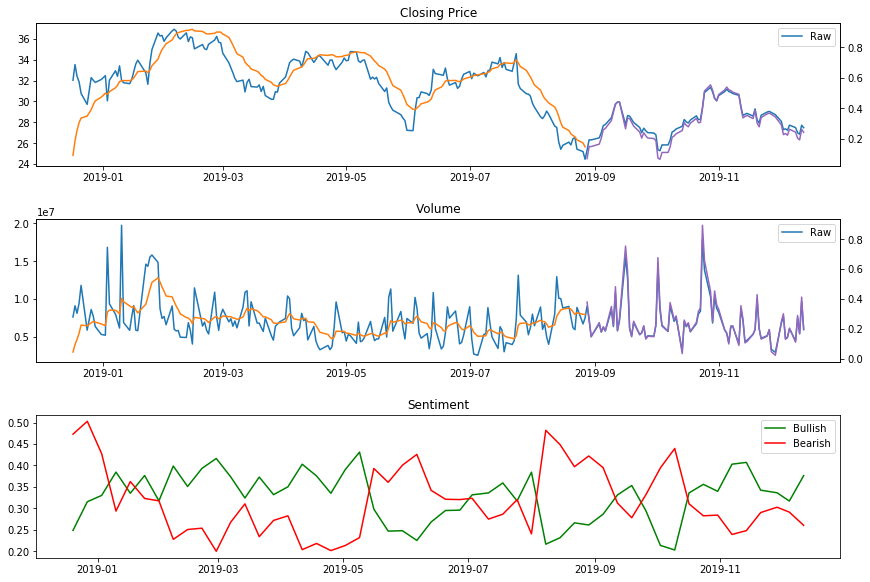

In [12]:
# Before normalization/ smoothing

AAL_close = AAL_df['Close']
AAL_date = AAL_df['Date']
AAL_vol = AAL_df['Volume']

sent_date = sent_df['Date']
sent_bull = sent_df['Bullish']
sent_bear = sent_df['Bearish']

# After normalization/ smoothing

AAL_close_fold_list, AAL_close_train_list, AAL_close_test_list = splitter(AAL_close, 0.7, 1)
AAL_date_fold_list, AAL_date_train_list, AAL_date_test_list = splitter(AAL_date, 0.7, 1)
AAL_vol_fold_list, AAL_vol_train_list, AAL_vol_test_list = splitter(AAL_vol, 0.7, 1)


AAL_close_train_list = AAL_close_train_list[0]      
AAL_close_test_list =  AAL_close_test_list[0]
AAL_date_train_list = AAL_date_train_list[0]
AAL_date_test_list = AAL_date_test_list[0]
AAL_vol_train_list = AAL_vol_train_list[0]
AAL_vol_test_list = AAL_vol_test_list[0]

'''
Hyperparameter Definition
'''
EMA = 0.0
gamma = 0.15
''''''

AAL_close_train_sm, AAL_close_test_sm = smoother_scaler(AAL_close_train_list, AAL_close_test_list, EMA, gamma)
AAL_vol_train_sm, AAL_vol_test_sm = smoother_scaler(AAL_vol_train_list, AAL_vol_test_list, EMA, gamma)

plt.figure(1)
fig, axs = plt.subplots(3, 1, figsize=(12,8))

axs[0].plot(AAL_date, AAL_close, label = "Raw", c = 'tab:blue')
axs01 = axs[0].twinx()  
axs01.plot(AAL_date_train_list, AAL_close_train_sm, label = "Smoothed", c = 'tab:orange')
axs01.plot(AAL_date_test_list, AAL_close_test_sm, label = "Smoothed", c = 'tab:purple')

axs[1].plot(AAL_date, AAL_vol, label = "Raw", c = 'tab:blue')
axs11 = axs[1].twinx()
axs11.plot(AAL_date_train_list, AAL_vol_train_sm, label = "Smoothed", c = 'tab:orange')
axs11.plot(AAL_date_test_list, AAL_vol_test_sm, label = "Smoothed", c = 'tab:purple')

axs[2].plot(sent_date, sent_bull, label = "Bullish", color='g')
axs[2].plot(sent_date, sent_bear, label = "Bearish", color='r')

axs[0].set_title("Closing Price")
axs[1].set_title("Volume")
axs[2].set_title("Sentiment")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)

axs[0].legend()
axs[1].legend()
axs[2].legend()
